In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/meta-electronics/meta_Electronics.json
/kaggle/input/reviews/Electronics_5.json


In [2]:
pip install pandas numpy scikit-learn transformers matplotlib seaborn

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import json
import os
import logging
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader  # Use PyTorch DataLoader
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from transformers import pipeline
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import ast  # For safely evaluating Python-style strings
from tqdm import tqdm  # Import tqdm for progress bars

In [4]:
logging.basicConfig(filename='model_log.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

def load_data(review_file, meta_file):
    print("Step 1: Starting to load data...")
    if not os.path.exists(review_file):
        raise FileNotFoundError(f"Review file not found: {review_file}")
    if not os.path.exists(meta_file):
        raise FileNotFoundError(f"Metadata file not found: {meta_file}")

    reviews = pd.read_json(review_file, lines=True)
    print(f"Reviews loaded: {len(reviews)} rows")
    logging.info("Reviews loaded successfully.")

    metadata_list = []
    with open(meta_file, 'r') as f:
        for line in f:
            try:
                data = ast.literal_eval(line.strip())
                metadata_list.append(data)
            except (ValueError, SyntaxError) as e:
                logging.warning(f"Failed to parse line: {line.strip()}. Error: {e}")
                continue
    metadata = pd.DataFrame(metadata_list)
    print(f"Metadata loaded: {len(metadata)} rows")
    logging.info("Metadata loaded successfully.")
    print("Step 1: Data loading completed.")
    return reviews, metadata

def preprocess_data(reviews, metadata):
    print("Step 2: Starting data preprocessing...")
    
    if 'helpful' in reviews.columns:
        reviews['helpful'] = reviews['helpful'].apply(lambda x: tuple(x) if isinstance(x, list) else x)
    reviews = reviews.drop_duplicates(subset=['reviewText', 'asin']).dropna(subset=['reviewText', 'asin'])
    print(f"Reviews after cleaning: {len(reviews)} rows")
    
    metadata = metadata.drop_duplicates(subset=['asin']).dropna(subset=['asin'])
    print(f"Metadata after cleaning: {len(metadata)} rows")
    
    electronics = metadata[metadata['categories'].apply(lambda x: any('Electronics' in sublist for sublist in x) if isinstance(x, list) else False)]
    print(f"Electronics metadata: {len(electronics)} rows")
    print("Sample categories:", electronics['categories'].head().tolist())
    
    reviews = reviews[reviews['asin'].isin(electronics['asin'])]
    print(f"Reviews filtered for electronics: {len(reviews)} rows")
    logging.info("Data preprocessed: duplicates removed, filtered for electronics.")
    print("Step 2: Data preprocessing completed.")
    return reviews, electronics

class ReviewDataset(Dataset):
    """Custom Dataset for reviews."""
    def __init__(self, reviews):
        self.reviews = reviews['reviewText'].tolist()

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return self.reviews[idx]

def extract_sentiment(reviews):
    print("Step 3: Starting sentiment analysis...")
    sentiment_pipeline = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        device=0  # GPU
    )
    
    batch_size = 32
    review_dataset = ReviewDataset(reviews)
    dataloader = DataLoader(review_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
    
    sentiments = []
    for batch in tqdm(dataloader, desc="Processing reviews for sentiment"):
        # Batch is a list of strings (reviews)
        results = sentiment_pipeline(list(batch), truncation=True, max_length=512)
        sentiments.extend([result['label'] for result in results])
    
    # Assign results back to DataFrame
    reviews = reviews.drop(columns=['sentiment', 'sentiment_score'], errors='ignore')
    reviews['sentiment'] = sentiments
    reviews['sentiment_score'] = reviews['sentiment'].map({'POSITIVE': 1, 'NEGATIVE': -1})
    
    print("Step 3: Sentiment analysis completed.")
    logging.info("Sentiment scores extracted.")
    return reviews

def aggregate_features(reviews, metadata):
    print("Step 4: Starting feature aggregation...")
    agg_reviews = reviews.groupby('asin').agg({
        'sentiment_score': 'mean',
        'overall': 'mean',
        'reviewText': 'count'
    }).rename(columns={'reviewText': 'review_count'})
    
    # Ensure valid, positive salesRank
    metadata['salesRank_numeric'] = metadata['salesRank'].apply(
        lambda x: x.get('Electronics') if isinstance(x, dict) and 'Electronics' in x and x['Electronics'] > 0 else np.nan
    )
    metadata['salesRank_log'] = np.log1p(metadata['salesRank_numeric'])
    features = agg_reviews.merge(metadata[['asin', 'price', 'salesRank_log']], on='asin', how='left')
    features = features.dropna()
    print(f"Features aggregated: {len(features)} products")
    logging.info("Features aggregated per product.")
    print("Step 4: Feature aggregation completed.")
    return features

def train_model(features, include_sentiment=True, target='salesRank_log'):
    print("Step 5: Starting model training...")
    X_cols = ['overall', 'review_count',]# 'price']
    if include_sentiment:
        X_cols.append('sentiment_score')
    X = features[X_cols]
    y = features[target]  # Flexible target
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Training set: {len(X_train)} samples, Test set: {len(X_test)} samples")
    
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    logging.info(f"Cross-validation R2 scores: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    logging.info(f"Model trained (sentiment={include_sentiment}). MSE: {mse:.2f}, R2: {r2:.3f}")
    print("Step 5: Model training completed.")
    return model, X_test, y_test, y_pred

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"MSE: {mse:.2f}, R-squared: {r2:.3f}")
    return mse, r2

def visualize_results(y_test, y_pred, model, X, target='salesRank_log'):
    print("Step 6: Generating visualizations...")
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test, y_pred, alpha=0.3)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel(f'Actual {target.replace("_", " ").title()}')
    plt.ylabel(f'Predicted {target.replace("_", " ").title()}')
    plt.title(f'Predicted vs. Actual {target.replace("_", " ").title()}')
    plt.show()

    importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': model.feature_importances_})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)
    plt.figure(figsize=(10, 5))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importance')
    plt.show()
    print("Step 6: Visualizations completed.")

def main(review_file, meta_file, sample_size=None, target='salesRank_log'):
    print("Starting main pipeline...")
    reviews, metadata = load_data(review_file, meta_file)
    
    if sample_size is not None:
        print(f"Sampling {sample_size} reviews for testing...")
        reviews = reviews.sample(n=sample_size, random_state=42)
        print(f"Sampled reviews: {len(reviews)} rows")
    
    reviews, electronics = preprocess_data(reviews, metadata)
    reviews = extract_sentiment(reviews)
    features = aggregate_features(reviews, electronics)
    
    print("\nRunning Baseline Model (No Sentiment):")
    model_base, X_test_base, y_test_base, y_pred_base = train_model(features, include_sentiment=False, target=target)
    mse_base, r2_base = evaluate_model(model_base, X_test_base, y_test_base)
    
    print("\nRunning Enhanced Model (With Sentiment):")
    model_sent, X_test_sent, y_test_sent, y_pred_sent = train_model(features, include_sentiment=True, target=target)
    mse_sent, r2_sent = evaluate_model(model_sent, X_test_sent, y_test_sent)
    
    print("\nComparative Analysis:")
    print(f"Baseline - MSE: {mse_base:.2f}, R2: {r2_base:.3f}")
    print(f"Enhanced - MSE: {mse_sent:.2f}, R2: {r2_sent:.3f}")
    mse_improvement = ((mse_base - mse_sent) / mse_base * 100) if mse_base != 0 else 0
    r2_improvement = ((r2_sent - r2_base) / r2_base * 100) if r2_base != 0 else 0
    print(f"MSE Improvement: {mse_improvement:.2f}%")
    print(f"R2 Improvement: {r2_improvement:.2f}%")
    
    visualize_results(y_test_sent, y_pred_sent, model_sent, X_test_sent, target=target)
    print("Pipeline completed.")

Starting main pipeline...
Step 1: Starting to load data...
Reviews loaded: 1689188 rows
Metadata loaded: 498196 rows
Step 1: Data loading completed.
Sampling 10000 reviews for testing...
Sampled reviews: 10000 rows
Step 2: Starting data preprocessing...
Reviews after cleaning: 10000 rows
Metadata after cleaning: 498196 rows
Electronics metadata: 498196 rows
Sample categories: [[['Electronics', 'Computers & Accessories', 'Cables & Accessories', 'Monitor Accessories']], [['Electronics', 'Computers & Accessories', 'Cables & Accessories', 'Monitor Accessories']], [['Electronics', 'Computers & Accessories', 'PDAs, Handhelds & Accessories', 'PDAs & Handhelds']], [['Electronics', 'Accessories & Supplies', 'Audio & Video Accessories', 'Remote Controls', 'TV Remote Controls']], [['Electronics', 'GPS & Navigation', 'Vehicle GPS', 'Trucking GPS']]]
Reviews filtered for electronics: 10000 rows
Step 2: Data preprocessing completed.
Step 3: Starting sentiment analysis...


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0
Processing reviews for sentiment: 100%|██████████| 313/313 [01:02<00:00,  5.01it/s]


Step 3: Sentiment analysis completed.
Step 4: Starting feature aggregation...


/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Features aggregated: 602 products
Step 4: Feature aggregation completed.

Running Baseline Model (No Sentiment):
Step 5: Starting model training...
Training set: 481 samples, Test set: 121 samples
Step 5: Model training completed.
MSE: 3.78, R-squared: 0.179

Running Enhanced Model (With Sentiment):
Step 5: Starting model training...
Training set: 481 samples, Test set: 121 samples
Step 5: Model training completed.
MSE: 4.00, R-squared: 0.130

Comparative Analysis:
Baseline - MSE: 3.78, R2: 0.179
Enhanced - MSE: 4.00, R2: 0.130
MSE Improvement: -5.97%
R2 Improvement: -27.46%
Step 6: Generating visualizations...


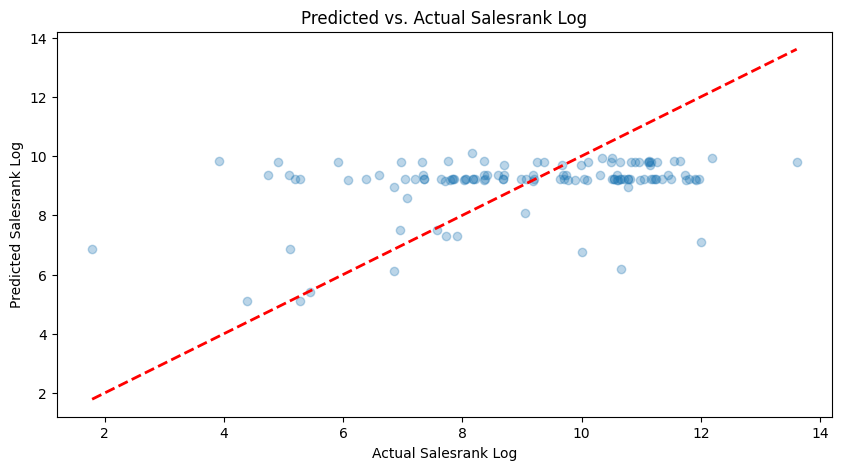

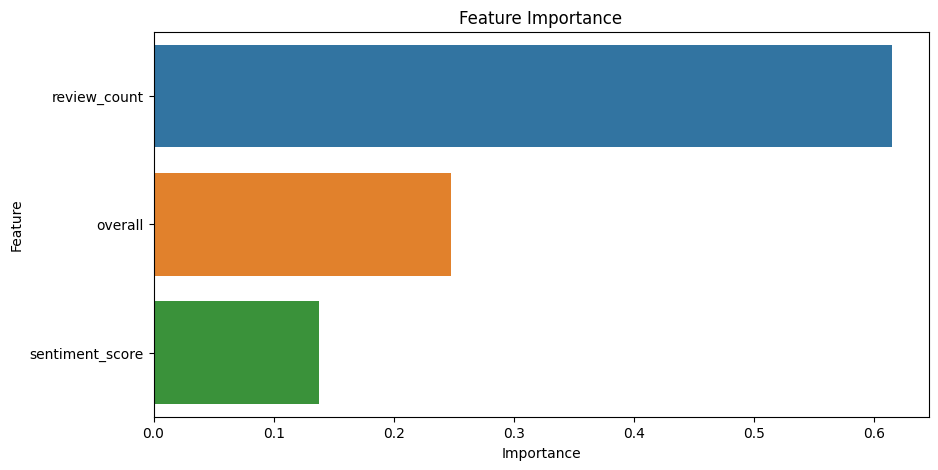

Step 6: Visualizations completed.
Pipeline completed.


In [5]:
if __name__ == "__main__":
    review_file = '/kaggle/input/reviews/Electronics_5.json'
    meta_file = '/kaggle/input/meta-electronics/meta_Electronics.json'
    main(review_file, meta_file, sample_size=10000, target='salesRank_log')  # Test with salesRank_log
    # main(review_file, meta_file, sample_size=1000, target='review_count')